# ANLP 2020 - Assignment 4


*Sophia Student, 1234567* (enter your name/student id number here)

<div class="alert alert-block alert-danger">Due: Wednesday, February 3rd 2021</div>

<div class="alert alert-block alert-info">

**NOTE**<br><br>

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-4.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle upload (we will provide a link). In case of questions, you can contact us via email, or via the Piazza (preferred).

</div>

## Structural ambiguity [20 pts]

<div class="alert alert-block alert-info">
    
Devise at least two sentences that exhibit structural ambiguity (i.e., ambiguity that comes from different structural analyses, not from ambiguity in the meaning of an individual lexical item). Indicate the different analyses (at least two per sentence) with a syntactic tree.

You can draw trees by using the NLTK package:

</div>

In [14]:
from nltk.tree import Tree
import nltk
import pandas as pd
import numpy as np
nltk.download('large_grammars')
import configparser


[nltk_data] Downloading package large_grammars to /home/local/MPIB-
[nltk_data]     BERLIN/raza/nltk_data...
[nltk_data]   Package large_grammars is already up-to-date!


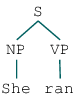

In [2]:
Tree.fromstring('(S (NP (She)) (VP (ran)))')

## CKY Parsing. Some Notes

<div class="alert alert-block alert-info">
    
In this assignment, you will implement the CKY algorithm for English and apply it to the word recognition and parsing problem. You can use the NLTK modules for representing context-free grammars and parse trees, but you should implement the parser from scratch. (But you don't *have* to use `nltk.grammar` if you find it easier without. Some NLTK modules are overly complicated, and in this assignment you mainly need a lookup function from right-hand-sides of grammar rules to left-hand-sides.)<br><br>

We provide the grammar and the test sentences.
The grammar stems from the Airline Travel Information System (ATIS), a project working on spoken dialog systems for air travel. (What do you think, is this a grammar motivated by syntactic theory, or perhaps more motivated by other concerns? Does it look like the sample grammars we've seen in class, only larger, or does it fundamentally look different?) The ATIS CFG is available in the NLTK data package, together with 98 test sentences. You can initialize the resources this way:

</div>

In [7]:
# load the grammar
grammar = nltk.data.load("grammars/large_grammars/atis.cfg")
# load the raw sentences
s = nltk.data.load("grammars/large_grammars/atis_sentences.txt", "auto")
# extract the test sentences
t = nltk.parse.util.extract_test_sentences(s)

<div class="alert alert-block alert-info">
    
NLTK already implements a number of parsing algorithms (see `nltk.parse` for the list). You can try one to see if you loaded the grammar correctly.<br><br>
Note that NLTK's `chart_parse()` throws an error when it encounters an unknown word, which is undesirable behavior for any parser. If you want to test the grammars with the pre-implemented parser (for example, to check whether the CNF version is in fact weakly equivalent), you may need to catch this error.

</div>

In [9]:
# initialize the parser
parser = nltk.parse.BottomUpChartParser(grammar)
# parse all test sentences
for sentence in t[:10]:
    parser.chart_parse(sentence[0])

<div class="alert alert-block alert-info">
    
However, the NLTK version of the ATIS grammar is not in Chomsky normal form (CNF), which you will need for your CKY parser. Feel free to implement a conversion module for extra credit, but for your convenience, we have already converted the ATIS CFG into CNF, provided with this assignment. You can then read the grammar from the file using `nltk.data.load()` and utilize the features of the `nltk.grammar` module on the resulting object.

</div>

### Problem 1: Word Recognition [50 pts]

<div class="alert alert-block alert-info">

Implement the CKY algorithm and use it as a recognizer. That is, given an input sentence, the procedure should decide whether the sentence is in the language of the CFG or not. 

</div>

In [237]:
df = pd.read_csv("dataset/atis-grammar-cnf.cfg", sep = '-> ', header= None, names= ['A', 'B'])
df.head()

,A,B
0,SIGMA,ADJ_ABL JYL
1,GCC,AVP_RB GCD
2,GCD,NP_DTS pt_char_per
3,GCA,AVP_RB GCB
4,GCB,COMPCL_VBZ pt_char_per


In [208]:
df['A'][0]

'SIGMA '

In [226]:
df['B'][16500] == "airplane"

True

In [236]:
df.iloc[6802]

A    NP_NP
B     None
Name: 6802, dtype: object

In [238]:
df['A'] = df['A'].apply(lambda x: x[:-1])
df['B'] = df['B'].apply(lambda x: x[1:-1] if x[0]=='"' else x)

In [256]:
a = "jamal khan      memor                       kk" + " "
a.split()

['jamal', 'khan', 'memor', 'kk']

In [301]:
def lookup(aa,bb):
    aa = aa.split()
    bb = bb.split()
    idx = ""
    for a in aa:
        for b in bb:
            look = a+" "+b
            idx += " ".join(df[df['B'] == look]['A'].tolist()) 
    return idx


In [295]:
n = 3
chart = np.zeros((n+2,n+2), dtype = "object")
chart[:,:]="hello"
chart[1,2] = chart[1,2] + " "+ "hhh"
chart

array([['hello', 'hello', 'hello', 'hello', 'hello'],
       ['hello', 'hello', 'hello hhh', 'hello', 'hello'],
       ['hello', 'hello', 'hello', 'hello', 'hello'],
       ['hello', 'hello', 'hello', 'hello', 'hello'],
       ['hello', 'hello', 'hello', 'hello', 'hello']], dtype=object)

In [298]:
(" "+"jj").split()

['jj']

In [299]:
# your code goes here
def cky(sentence, df= df):
    words = sentence.split()
    n = len(words)
    chart = np.zeros((n+2,n+2), dtype = "object")
    chart[:,:] = ""
    for i, w in enumerate(words):
        idx = df[df['B'] == w]['A'].tolist()
        chart[i+1, i+2] = " ".join(idx)
    

    #
    for b in range(2, n+1):
        for i in range(1, n-b+2):
            for k in range(1,b):
                chart[i, i+b] = chart[i, i+b] + " " + lookup(chart[i,i+k], chart[i+k, i+b])

    if "SIGMA" in chart[1,n+1].split():
        print("SENTENCE CAN BE MADE USING VOCABLARY")
    else:
        print("Sorry, the sentence cannot be made using this vocablary")
    return chart

In [304]:
#chart = cky("get the hell out of here")
#chart = cky("are you free")
#chart = cky("john live in city")
chart = cky("a good day")

Sorry, the sentence cannot be made using this vocablary


In [305]:
chart

array([['', '', '', '', ''],
       ['', '',
        'NOUN_NP ADJ_AT NP_NP a SIGMA AVPNP_NP PREP_IN NAPPOS_NP', ' ',
        '  '],
       ['', '', '', '', ' '],
       ['', '', '', '', 'NOUN_NN NP_NN SIGMA AVPNP_NN pt120'],
       ['', '', '', '', '']], dtype=object)

<div class="alert alert-block alert-info">

Provide a list of grammatical and ungrammatical test sentences (at least 10 each) and test your recognizer on these sentences. 

</div>

*your code/discussion goes here*

### Problem 2: Parsing [30 pts]

<div class="alert alert-block alert-info">

Now extend your CKY recognizer into a parser by adding backpointers. Also implement a function that extracts the set of all parse trees from the backpointers in the chart. Feel free to use the NLTK module `nltk.tree` for this purpose; notice that only `ImmutableTree`s can be used as elements of Python sets, whereas raw `Tree`s cannot.

</div>

In [ ]:
# your code goes here

<div class="alert alert-block alert-info">

Test the parser by providing the list of ATIS test sentences with tab-separated numbers of parse trees.

</div>

*your code/results go here*

<div class="alert alert-block alert-info">

Choose an ATIS test sentence with a number of parses $p$ such that $1 < p < 5$. Provide pictures of its parses. You can visualize an NLTK tree using its `draw` method. Discuss the structural differences.

</div>

*your code/results go here*

### Extra Credit [10 pts]

<div class="alert alert-block alert-info">

If you still have time left, you can attempt the following project for extra credit. Perhaps it has occurred to you that it is quite wasteful to compute all parse trees just to find out how many parse trees there are. Figure out how to compute the number of parse trees for an entry $A ∈ Ch(i, k)$ from your chart with backpointers, without actually computing these parse trees. Verify that you get the correct results, and compare the efficiency of your new procedure to your earlier solution.

</div>

In [ ]:
# your code goes here